In [1]:
import os
import pathlib
import numpy as np
import cv2
import torch
from glob import glob
import torchvision.transforms as tf
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm, trange
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import transforms
from torch.utils.data import WeightedRandomSampler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from typing import Tuple, Dict, List


In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
learning_rate = 1e-4
batch_size = 16
num_workers = 0


In [3]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    if not classes:
        
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
    
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    
    return classes, class_to_idx


In [4]:
class ImageFolderCustom(Dataset):

    def __init__(self, targ_dir: str, transform=None) -> None:
        
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.npy"))

        self.transform = transform

        self.classes, self.class_to_idx = find_classes(targ_dir)
        

    def load_image(self, index: int) -> Image.Image:

        image_path = self.paths[index]
        
        return np.load(image_path) 
    
    def __len__(self) -> int:

        return len(self.paths)
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:

        img = self.load_image(index)
        img = np.expand_dims(img, axis = 0)
        class_name  = self.paths[index].parent.name 
        class_idx = self.class_to_idx[class_name]

        if self.transform:
            
            return self.transform(img), class_idx 
        
        else:
            
            return img, class_idx 
        

In [5]:
train_img_dir = 'E:/Tanvir Mehedi/Nodule_Classification/Data/train/'

val_img_dir = 'E:/Tanvir Mehedi/Nodule_Classification/Data/validation/'


In [6]:
model_save_dir = 'E:/Tanvir Mehedi/Nodule_Classification/Saved_models/Base_NN_model/'


In [7]:
img_dir = train_img_dir

no_of_subdirectories = len(glob(img_dir + '*'))

subdirectories = [glob(img_dir + '*')[i].split('\\')[-1] for i in range(no_of_subdirectories) ]
subdirectories


['neg_cube', 'pos_cube']

In [8]:
no_of_subdirectories = len(glob(img_dir + '*'))
subdirectories = [glob(img_dir + '*')[i].split('\\')[-1] for i in range(no_of_subdirectories) ]

class_weights = []

for subdir in subdirectories:
    files = os.listdir(os.path.join(img_dir, subdir))
    class_weights.append(1 / len(files))
    
class_weights  


[3.797184767213588e-06, 7.23589001447178e-05]

In [ ]:
train_ds = ImageFolderCustom(
#         targ_dir = train_img_dir,
        targ_dir = img_dir,
        transform = None,
    )

sample_weights = [0] * len(train_ds)

for idx, (data, label) in tqdm(enumerate(train_ds)):
    
    class_weight = class_weights[label]
    sample_weights[idx] = class_weight

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(
        train_ds,
        batch_size = batch_size,
        sampler = sampler,
        num_workers = num_workers,
        drop_last = True,
    )


0it [00:00, ?it/s]

In [ ]:
# train_ds = ImageFolderCustom(
#         targ_dir = train_img_dir,
#         transform = None,
#     )

# train_loader = DataLoader(
#         train_ds,
#         batch_size = batch_size,
#         num_workers = num_workers,
#         shuffle = True,
#         drop_last = True,
#     )


In [9]:
val_ds = ImageFolderCustom(
        targ_dir = val_img_dir,
        transform = None,
    )

val_loader = DataLoader(
        val_ds,
        batch_size = batch_size,
        num_workers = num_workers,
        shuffle = False,
        drop_last = True,
    )


In [28]:
from model_paper import Base_NN_Model

model =  Base_NN_Model()
model = model.to(device)


In [ ]:
# from ResNet3D_model import ResNet3D

# model =  ResNet3D()
# model = model.to(device)

In [ ]:
# Define the class frequencies

# no_of_pos_files = 18657
# no_of_neg_files = 263353

# positive_frequency = no_of_pos_files/(no_of_pos_files + no_of_neg_files)
# negative_frequency = 1 - positive_frequency

# # Assign weights to each class proportional to the inverse of its frequency

# positive_weight = 1 / positive_frequency
# negative_weight = 1 / negative_frequency

# # Normalize the weights so that they sum up to 1

# total_weight = positive_weight + negative_weight
# positive_weight /= total_weight
# negative_weight /= total_weight

# # Define the class weights tensor

# class_weights = torch.FloatTensor([negative_weight, positive_weight]).to(device)

# class_weights


In [11]:
optimizer = torch.optim.AdamW(params = model.parameters(), lr = learning_rate) 
# optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

loss_criterion = torch.nn.CrossEntropyLoss()
# loss_criterion = torch.nn.CrossEntropyLoss(weight = class_weights)


In [12]:
results = {"train_loss": [],
        "train_accuracy": [],
        "validation_loss": [],
        "validation_accuracy": []
    }


In [29]:
len(train_loader)


17323

In [30]:
for epoch in range(1):
    pos = 0
    neg = 0
    
    for itera_no, data in tqdm(enumerate(train_loader)):
        
        images, labels = data
        images, labels = images.to(device), labels.to(device)

#         print(labels)
        
        neg += torch.sum(labels == 0)
        pos += torch.sum(labels == 1)
        
print(pos,neg)


0it [00:00, ?it/s]

tensor(138853, device='cuda:0') tensor(138315, device='cuda:0')


In [14]:
root_dir = 'E:/Tanvir Mehedi/Nodule_Classification/Saved_models/Base_NN_model/'

def save_checkpoint(state, filename = root_dir + 'val_checkpoint_Base_NN_model.pt.tar'):
    
    print('=> Saving Checkpoint')
    torch.save(state, filename)
    
def save_sensitive_checkpoint(state, filename = root_dir + 'val_sensitive_Base_NN_model_checkpoint.pt.tar'):
    
    print('=> Saving Checkpoint')
    torch.save(state, filename)
    

In [31]:
def auc_roc_calc(all_labels, pos_preds):
    
    all_labels_on_cpu = []

    for tensor in all_labels:
        tensor_on_cpu = tensor.cpu().numpy()
        all_labels_on_cpu.append(tensor_on_cpu)

    pos_preds_on_cpu = []

    for tensor in pos_preds:
        tensor_on_cpu = tensor.cpu().numpy()
        pos_preds_on_cpu.append(tensor_on_cpu)

    auc_roc = roc_auc_score(all_labels_on_cpu, pos_preds_on_cpu)
    
    return all_labels_on_cpu, pos_preds_on_cpu, auc_roc


In [16]:
total_epochs = 50

best_score = 0
best_sen_score = 0
best_auc_roc = 0
all_auc_roc = []


In [59]:
for epoch in range(1, total_epochs+1):
    
    model.train()
    optimizer.zero_grad()
    
    train_loss = 0
    CM = 0
    
    pbar = tqdm(train_loader, desc='Epoch: {}'.format(epoch))
    
    for itera_no, data in enumerate(pbar):
        
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        out = model(images)
        
        
        loss = loss_criterion(out, labels)
    
        train_loss += loss.item()
        loss.backward()
        
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm =2.0, norm_type=2.0)
        optimizer.step()
        optimizer.zero_grad()
        
        pred_class = torch.argmax(torch.nn.functional.softmax(out, dim = 1), dim = 1)
        
          
    train_loss = train_loss / len(train_loader)
    results['train_loss'].append(train_loss)
  
    print(epoch,") Training Loss : ", train_loss)
    
    model.eval() 
    
    val_loss =  0
    val_acc = 0
    
    all_labels = []
    all_preds = []
    pos_preds = []

    with torch.inference_mode():

        for itera_no, val_data in tqdm(enumerate(val_loader)):

            val_images, val_labels = val_data
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            all_labels.append(val_labels)

            val_pred_logits = model(val_images)

            v_loss = loss_criterion(val_pred_logits, val_labels)
            val_loss += v_loss.item()
            
            for pos_logit in val_pred_logits:
    
                pos_preds.append(torch.sigmoid(pos_logit[1]))
        
            all_preds.append(torch.sigmoid(val_pred_logits))
        
            val_class =  torch.argmax(torch.nn.functional.softmax(val_pred_logits, dim = 1), dim = 1)          
            
            CM+=confusion_matrix(val_labels.cpu(), val_class.cpu(), labels = [0,1]) 


    val_loss = val_loss / len(val_loader)
    results['validation_loss'].append(val_loss)
    
    tn=CM[0][0]
    tp=CM[1][1]
    fp=CM[0][1]
    fn=CM[1][0]
    acc=np.sum(np.diag(CM)/np.sum(CM))
    sensitivity=tp/(tp+fn)
    precision=tp/(tp+fp)
    F1 = ((2*sensitivity*precision)/(sensitivity+precision))*100
    
    _, _, auc_roc = auc_roc_calc(all_labels, pos_preds)
    all_auc_roc.append(auc_roc)
    
    print('\nValidation Accuracy(mean): %f %%' % (100 * acc))
    print()
    print('Confusion Matirx : ')
    print(CM)
    print('- Sensitivity : ',(tp/(tp+fn))*100)
    print('- Specificity : ',(tn/(tn+fp))*100)
    print('- Precision: ',(tp/(tp+fp))*100)
    print('- NPV: ',(tn/(tn+fn))*100)
    print('- F1 : ',F1)
    print('AUC', auc_roc)
    
    print(epoch,") Validation Loss : ", val_loss)

    if F1>best_score:
        
        best_score = F1
        
        val_checkpoint = {'model_state' : model.state_dict(), 'optimizer_state' : optimizer.state_dict(), 
                               'F1_Score' : F1, 'val_sensitivity_score' : sensitivity, 'AUC_ROC' : auc_roc } 
        save_checkpoint(val_checkpoint)
        
        print("Saving Model with F1 score :", F1)
        
        torch.save(model.state_dict(), model_save_dir + 'best_F1_model_Base_NN' + ".torch")
        
    if sensitivity>best_sen_score:
        
        best_sen_score = sensitivity
        
        val_sensitive_checkpoint = {'model_state' : model.state_dict(), 'optimizer_state' : optimizer.state_dict(), 
                              'F1_Score' : F1, 'val_sensitivity_score' : sensitivity, 'AUC_ROC' : auc_roc } 
        save_sensitive_checkpoint(val_sensitive_checkpoint)
        
        print("Saving Sensitive Model with sensitivity :", sensitivity)
        
        torch.save(model.state_dict(), model_save_dir + 'best_sensitive_model_Base_NN' + ".torch")
    

Epoch: 1:   0%|          | 0/17323 [00:00<?, ?it/s]

1 ) Training Loss :  0.7507112640497186


0it [00:00, ?it/s]

ValueError: Found input variables with inconsistent numbers of samples: [3791, 60656]

# Testing

# Test_dataset_define


In [17]:
test_img_dir = 'E:/Tanvir Mehedi/Nodule_Classification/Data/test/'

test_ds = ImageFolderCustom(
        targ_dir = test_img_dir,
        transform = None,
    )

test_loader = DataLoader(
        test_ds,
        batch_size = 1,
        num_workers = num_workers,
        shuffle = False,
        drop_last = True,
    )


# Saved_model_load

In [18]:
model.load_state_dict(torch.load(model_save_dir + 'best_model_paper.torch', map_location = device))


<All keys matched successfully>

# Perform_testing

In [19]:
model.eval() 

test_loss =  0
test_CM = 0

all_labels = []
all_preds = []
pos_preds = []

with torch.inference_mode():

    for itera_no, test_data in tqdm(enumerate(test_loader)):

        test_images, test_labels = test_data
        test_images, test_labels = test_images.to(device), test_labels.to(device)
        
        all_labels.append(test_labels)
        
        test_pred_logits = model(test_images)

        test_loss_batch = loss_criterion(test_pred_logits, test_labels)
        test_loss += test_loss_batch.item()

        test_class =  torch.argmax(torch.sigmoid(test_pred_logits), dim = 1)
#         print(test_class.item(), test_labels.item())
        
        pos_preds.append(torch.sigmoid(test_pred_logits)[0][1])
        all_preds.append(torch.sigmoid(test_pred_logits))
        
        test_CM+=confusion_matrix(test_labels.cpu(), test_class.cpu(), labels = [0,1]) 

test_loss = test_loss / len(test_loader)


print(") Test Loss : ", test_loss)

tn= test_CM[0][0]
tp=test_CM[1][1]
fp=test_CM[0][1]
fn=test_CM[1][0]
acc=np.sum(np.diag(test_CM)/np.sum(test_CM))
sensitivity=tp/(tp+fn)
precision=tp/(tp+fp)
F1 = ((2*sensitivity*precision)/(sensitivity+precision))*100
all_labels_on_cpu, pos_preds_preds_on_cpu, auc_roc = auc_roc_calc(all_labels, pos_preds)

print('\nTest Accuracy(mean): %f %%' % (100 * acc))
print()
print('Confusion Matirx : ')
print(test_CM)
print('- Sensitivity : ',(tp/(tp+fn))*100)
print('- Specificity : ',(tn/(tn+fp))*100)
print('- Precision: ',(tp/(tp+fp))*100)
print('- NPV: ',(tn/(tn+fn))*100)
print('- F1 : ',F1)
print()


0it [00:00, ?it/s]

) Test Loss :  0.7841772686422885


NameError: name 'all_preds_on_cpu' is not defined

In [23]:
tn= test_CM[0][0]
tp=test_CM[1][1]
fp=test_CM[0][1]
fn=test_CM[1][0]
acc=np.sum(np.diag(test_CM)/np.sum(test_CM))
sensitivity=tp/(tp+fn)
precision=tp/(tp+fp)
F1 = ((2*sensitivity*precision)/(sensitivity+precision))*100
all_labels_on_cpu, pos_preds_preds_on_cpu, auc_roc = auc_roc_calc(all_labels, pos_preds)

print('\nTest Accuracy(mean): %f %%' % (100 * acc))
print()
print('Confusion Matirx : ')
print(test_CM)
print('- Sensitivity : ',(tp/(tp+fn))*100)
print('- Specificity : ',(tn/(tn+fp))*100)
print('- Precision: ',(tp/(tp+fp))*100)
print('- NPV: ',(tn/(tn+fn))*100)
print('- F1 : ',F1)
print('- AUC : ' , auc_roc)


Test Accuracy(mean): 94.527741 %

Confusion Matirx : 
[[60860  3497]
 [   36   169]]
- Sensitivity :  82.4390243902439
- Specificity :  94.56624764982831
- Precision:  4.609929078014184
- NPV:  99.94088281660535
- F1 :  8.731593903384137
- AUC :  0.9427285753970706


AUC_PR : 0.14048534892864237


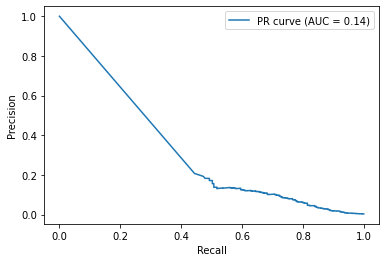

In [26]:
precision, recall, _ = precision_recall_curve(all_labels_on_cpu, pos_preds_preds_on_cpu)
auc_pr = average_precision_score(all_labels_on_cpu, pos_preds_preds_on_cpu)
print('AUC_PR :', auc_pr)

plt.plot(recall, precision, label='PR curve (AUC = %0.2f)' % auc_pr)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()


# Plot_Auc_Roc_curve

In [ ]:
fpr, tpr, thresholds = roc_curve(all_labels_on_cpu, pos_preds_preds_on_cpu)

# calculate ROC AUC score
roc_auc = roc_auc_score(all_labels_on_cpu, all_preds_on_cpu)

# plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


# Check_misclassified_test_data

In [ ]:
model.eval() 

test_loss =  0
test_CM = 0

with torch.inference_mode():

    for itera_no, test_data in tqdm(enumerate(test_loader)):

        test_images, test_labels = test_data
        test_images, test_labels = test_images.to(device), test_labels.to(device)

        test_pred_logits = model(test_images)

        test_class =  torch.argmax(torch.sigmoid(test_pred_logits), dim = 1)
#         print(test_class.item(), test_labels.item())
        
        test_CM+=confusion_matrix(test_labels.cpu(), test_class.cpu(), labels = [0,1]) 
        
#         if test_labels == 1 :
        if test_labels != test_class and test_labels == 0:
            
            print(itera_no)
        
print(test_CM)



In [ ]:
arr_fn = [8,13,15,18,24,59,60,70,79,82,83,84,100,104,121,137,139,140,141]

In [ ]:
arr_fp = [41,97,104,125,127,218,235,253,264,279,286,299,303,311,321,328,336,339,340,383,395,476,493,527,545]